In [9]:
%load_ext autoreload
%autoreload 2

In [49]:
import duckdb

from splink.duckdb.linker import DuckDBLinker
import splink.duckdb.comparison_library as cl
import splink.duckdb.comparison_template_library as ctl

import altair as alt
alt.renderers.enable("mimetype")

from cmf.data import utils as du
from cmf.features.clean_basic import (
    clean_company_name,
    clean_stopwords,
    list_join_to_string
)
import cmf.locations as loc
from cmf.config import stopwords

# Splink example

Linking 5% samples from Companies House and HMRC Exporters to show a Splink workflow.

## Get data

We can get data directly from Companies House, but HMRC Exporters contains duplicated entities. Splink requires indepdendence of observations. I therefore am reading in a very roughly deduped version of the dataset.

In [27]:
ch_raw = du.query(
f"""
select
    id,
    company_name,
    postcode
from
    companieshouse.companies tablesample system (5);
"""
)

In [28]:
exp_raw = du.query(
f"""
select
    id,
    company_name,
    postcode
from
    _user_eaf4fd9a.hmrc_trade__exporters__dim tablesample system (5);
"""
)

In [29]:
ch_raw.info()
exp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272681 entries, 0 to 272680
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            272681 non-null  object
 1   company_name  272681 non-null  object
 2   postcode      272681 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739 entries, 0 to 12738
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            12739 non-null  int64 
 1   company_name  12739 non-null  object
 2   postcode      12739 non-null  object
dtypes: int64(1), object(2)
memory usage: 298.7+ KB


## Clean data

duckDB allows you to use SQL on pandas dataframes. I'm using it because it means we can use the same cleaning functions on the remote Postgres database as we use to clean stuff in-memory here. It's efficient.

I'm also using simple cleaning functions to be explicit -- we have more complex ones available.

Adding more functions to `src.features.clean_basic` and `src.features.clean_complex` is a core part of the task.

In [30]:
ch_clean_step_1 = duckdb.sql(
f"""
    select
        id,
        {clean_company_name("company_name")} as company_name,
        postcode
    from
        ch_raw
"""
).df()
ch_clean_step_2 = duckdb.sql(
f"""
    select
        id,
        {clean_stopwords("company_name", stopwords=stopwords)} as company_name,
        postcode
    from
        ch_clean_step_1
"""
).df()
ch_clean = duckdb.sql(
f"""
    select
        id,
        {list_join_to_string("company_name")} as company_name,
        postcode
    from
        ch_clean_step_2
"""
).df()

In [31]:
ch_clean.sample(3)

,id,company_name,postcode
207450,13127527,roj made,SW6 1NY
21222,03376471,arnold green pension scheme trustees,EC3M 5JE
271087,09198508,yvonne school wear,EN4 8RQ


In [32]:
exp_clean_step_1 = duckdb.sql(
f"""
    select
        id,
        {clean_company_name("company_name")} as company_name,
        postcode
    from
        exp_raw
"""
).df()
exp_clean_step_2 = duckdb.sql(
f"""
    select
        id,
        {clean_stopwords("company_name", stopwords=stopwords)} as company_name,
        postcode
    from
        exp_clean_step_1
"""
).df()
exp_clean = duckdb.sql(
f"""
    select
        id,
        {list_join_to_string("company_name")} as company_name,
        postcode
    from
        exp_clean_step_2
"""
).df()

In [33]:
exp_clean.sample(3)

,id,company_name,postcode
3596,567601,eye emporium,E3 5LH
11133,1907344,tecnicas reunidas,SW1Y 4LB
11980,2476184,van rees north america,AB10 1ZP


## Set linker up

Here you can see the levels we discussed in the "comparisons" part of the settings dictionary. `cl` and `ctl` are the Comparisons Library and Comparisons Template Library, tools Splink provides so you can make some basic matches right away.

We'd look to do something more bespoke for addresses.

Blocking rules will become extremely important. Strictly speaking we want to calculate the probability that every record matches every other record between tables, but this is exponentially expensive to compute. Blocking rules help Splink compare only things that stand a chance of being the same. Here the name OR postcode must match for us to bother comparing.

In [34]:
settings = {
    "link_type": "link_only",
    "unique_id_column_name": "id",
    "retain_matching_columns": False,
    "retain_intermediate_calculation_columns": False,
    "blocking_rules_to_generate_predictions": [
        """
            (l.company_name = r.company_name)
            and (
                l.company_name <> ''
                and r.company_name <> ''
            )
        """,
        """
            (l.postcode = r.postcode)
            and (
                l.postcode <> ''
                and r.postcode <> ''
            )
        """,
    ],
    "comparisons": [
        cl.jaro_winkler_at_thresholds(
            "company_name", [0.9, 0.6], term_frequency_adjustments=True
        ),
        ctl.postcode_comparison("postcode"),
    ],
}

In [35]:
linker = DuckDBLinker(
    input_table_or_tables=[
        ch_clean,
        exp_clean
    ],
    input_table_aliases=[
        "ch",
        "exp"
    ],
    settings_dict=settings,
)

## Train linker

Here's where we do some of the stuff I didn't cover -- estimating probabilities. You'd be free to play with this methodology a little, but I'd expect you'd land on something common to all the different cleaning methods you tried, so it'd be a one time thing.

In [36]:
linker.estimate_probability_two_random_records_match(
    deterministic_matching_rules="""
        l.company_name = r.company_name
    """,
    recall=0.7
)

Probability two random records match is estimated to be  2.28e-07.
This means that amongst all possible pairwise record comparisons, one in 4,381,222.13 are expected to match.  With 3,473,683,259 total possible comparisons, we expect a total of around 792.86 matching pairs


In [37]:
linker.estimate_u_using_random_sampling(
    max_pairs=1e5
)

----- Estimating u probabilities using random sampling -----
u probability not trained for company_name - Exact match (comparison vector value: 3). This usually means the comparison level was never observed in the training data.
u probability not trained for company_name - Jaro_winkler_similarity >= 0.9 (comparison vector value: 2). This usually means the comparison level was never observed in the training data.

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - company_name (some u values are not trained, no m values are trained).
    - postcode (no m values are trained).


In [38]:
linker.estimate_parameters_using_expectation_maximisation(
    blocking_rule="""
        l.company_name = r.company_name
    """
)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:

        l.company_name = r.company_name
    

Parameter estimates will be made for the following comparison(s):
    - postcode

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - company_name

Iteration 1: Largest change in params was 0.281 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.166 in probability_two_random_records_match
Iteration 3: Largest change in params was -0.0605 in the m_probability of postcode, level `Exact match postcode`
Iteration 4: Largest change in params was 0.131 in the m_probability of postcode, level `Exact match Postcode Area`
Iteration 5: Largest change in params was 0.066 in the m_probability of postcode, level `Exact match Postcode Area`
Iteration 6: Largest change in params was 0.00455 in the m_probability of postcode, level `Exact match Postcode Area

<EMTrainingSession, blocking on 
        l.company_name = r.company_name
    , deactivating comparisons company_name>

In [39]:
linker.estimate_parameters_using_expectation_maximisation(
    blocking_rule="""
        l.postcode = r.postcode
    """
)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:

        l.postcode = r.postcode
    

Parameter estimates will be made for the following comparison(s):
    - company_name

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - postcode

Iteration 1: Largest change in params was 0.0497 in the m_probability of company_name, level `Exact match`
Iteration 2: Largest change in params was 0.000752 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.000241 in probability_two_random_records_match
Iteration 4: Largest change in params was 2.74e-06 in probability_two_random_records_match

EM converged after 4 iterations

Your model is not yet fully trained. Missing estimates for:
    - company_name (some u values are not trained).


<EMTrainingSession, blocking on 
        l.postcode = r.postcode
    , deactivating comparisons postcode>

## Predict links

We've fitted the model. Let's calculate the probabilities records are linked, and keep any over 0.7. Note we expect awful performance as this is a tiny sample.

In [44]:
predictions_duckdb = linker.predict(threshold_match_probability=0.7)
predictions = predictions_duckdb.as_pandas_dataframe()


 -- WARNING --
You have called predict(), but there are some parameter estimates which have neither been estimated or specified in your settings dictionary.  To produce predictions the following untrained trained parameters will use default values.
Comparison: 'company_name':
    u values not fully trained


In [45]:
predictions.head(10)

,match_weight,match_probability,source_dataset_l,source_dataset_r,id_l,id_r,match_key
0,7.241291,0.993434,ch,exp,10796240,1189196,0
1,3.904385,0.937398,ch,exp,12768525,3102506,0
2,7.826253,0.995613,ch,exp,11847537,2287041,0
3,7.241291,0.993434,ch,exp,03069535,2800687,0
4,7.241291,0.993434,ch,exp,10796240,1924738,0
5,7.826253,0.995613,ch,exp,03488862,1277794,0
6,7.826253,0.995613,ch,exp,06498279,2667482,0
7,6.504325,0.989105,ch,exp,07127476,3397781,0
8,6.504325,0.989105,ch,exp,07127476,2947920,0
9,2.582457,0.856930,ch,exp,07127476,631566,0


## Evaluate

Here's where you'd need to do some manual labelling to assess a methodology. [Splink has a clerical labelling tool in the works](https://github.com/moj-analytical-services/splink/pull/1208) but it's not deployed yet. You'd have to do this by hand.

We can also peek into the linker to see various stats about its configuration.

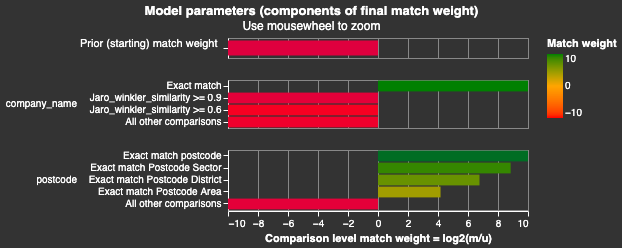

In [50]:
linker.match_weights_chart()

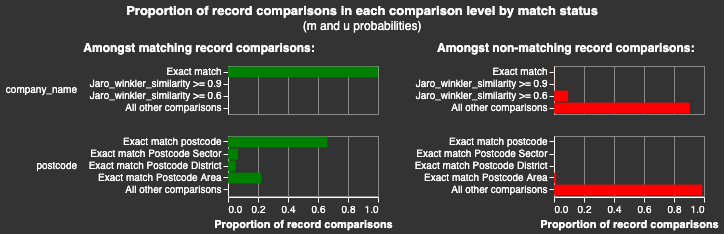

In [51]:
linker.m_u_parameters_chart()

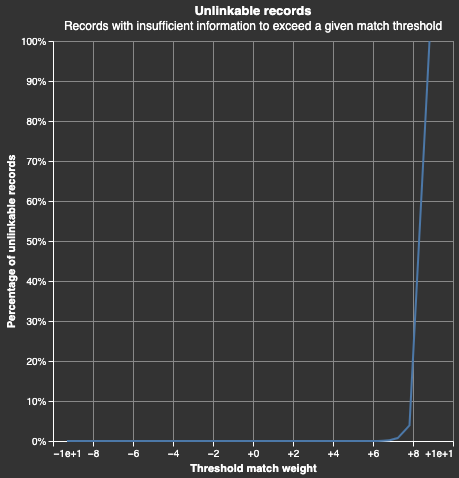

In [52]:
linker.unlinkables_chart()